## Setup: Read in All the Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_paths = [
    "data/prices_round_1_day_-2.csv", 
    "data/prices_round_1_day_-1.csv", 
    "data/prices_round_1_day_0.csv"
]

combined_df = pd.concat([pd.read_csv(file, delimiter=';') for file in file_paths], ignore_index=True)

combined_df['full_time'] = combined_df['day'].astype(str) + "_" + combined_df['timestamp'].astype(str)
# Convert mid_price to a string, clean it (remove extra whitespace, and replace commas with periods if needed),
# then convert to numeric and drop rows that cannot be converted.
combined_df['mid_price'] = combined_df['mid_price'].astype(str).str.strip()
combined_df['mid_price'] = combined_df['mid_price'].str.replace(',', '.', regex=False)
combined_df['mid_price'] = pd.to_numeric(combined_df['mid_price'], errors='coerce')
combined_df.dropna(subset=['mid_price'], inplace=True)
combined_df = combined_df.sort_values(by=['day', 'timestamp'])


squid_ink_df = combined_df[combined_df['product'] == 'SQUID_INK'].reset_index(drop=True)
rainforest_resin_df = combined_df[combined_df['product'] == 'RAINFOREST_RESIN'].reset_index(drop=True)
kelp_df = combined_df[combined_df['product'] == 'KELP'].reset_index(drop=True)

squid_ink_df.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,full_time
0,-2,0,SQUID_INK,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0,-2_0
1,-2,100,SQUID_INK,1999,5,1998.0,26.0,NaN,NaN,2001,20,NaN,NaN,NaN,NaN,2000.0,0.0,-2_100
2,-2,200,SQUID_INK,1997,31,NaN,NaN,NaN,NaN,2000,1,2001.0,30.0,NaN,NaN,1998.5,0.0,-2_200
3,-2,300,SQUID_INK,1997,27,NaN,NaN,NaN,NaN,2000,27,NaN,NaN,NaN,NaN,1998.5,0.0,-2_300
4,-2,400,SQUID_INK,1996,20,NaN,NaN,NaN,NaN,2000,20,NaN,NaN,NaN,NaN,1998.0,0.0,-2_400


## Simple Graphs to Show Price Over Time

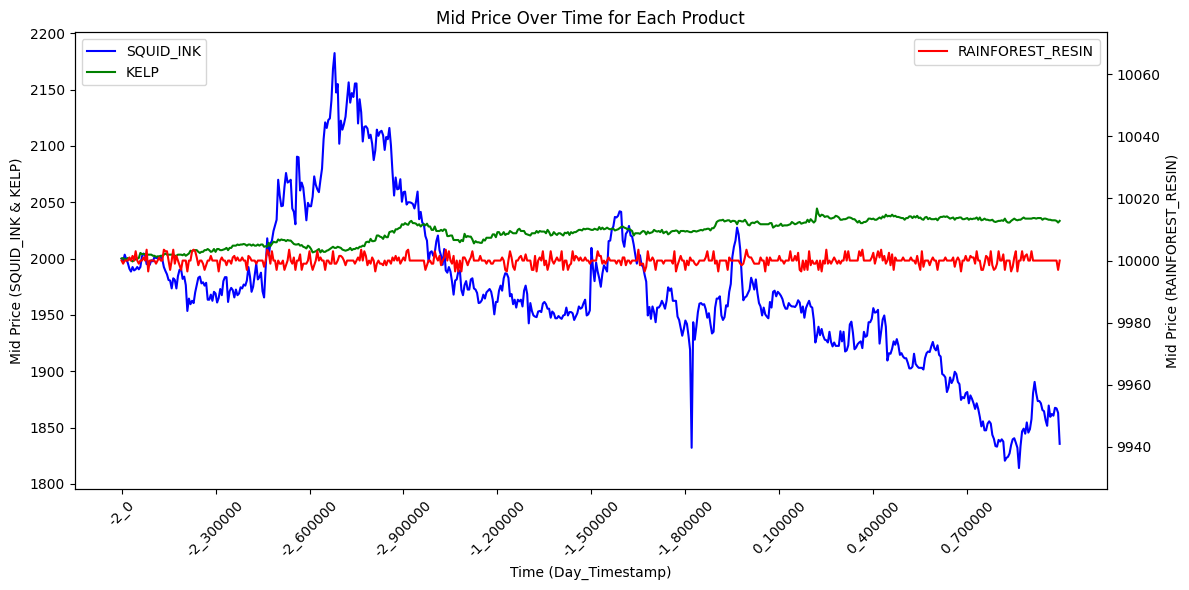

In [3]:
# downsample by taking every 50th point
squid_ink_df_downsized = combined_df[combined_df['product'] == 'SQUID_INK'].iloc[::50].reset_index(drop=True)
rainforest_resin_df_downsized = combined_df[combined_df['product'] == 'RAINFOREST_RESIN'].iloc[::50].reset_index(drop=True)
kelp_df_downsized = combined_df[combined_df['product'] == 'KELP'].iloc[::50].reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(squid_ink_df_downsized['full_time'], squid_ink_df_downsized['mid_price'], label='SQUID_INK', color='blue')
ax1.plot(kelp_df_downsized['full_time'], kelp_df_downsized['mid_price'], label='KELP', color='green')

ax1.set_xlabel('Time (Day_Timestamp)')
ax1.set_ylabel('Mid Price (SQUID_INK & KELP)')
ax1.set_title('Mid Price Over Time for Each Product')
ax1.legend(loc='upper left')

x_ticks = squid_ink_df_downsized['full_time'][::max(1, len(squid_ink_df_downsized) // 10)]
ax1.set_xticks(x_ticks)
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(rainforest_resin_df_downsized['full_time'], rainforest_resin_df_downsized['mid_price'], label='RAINFOREST_RESIN', color='red')

rain_min = rainforest_resin_df_downsized['mid_price'].min()
rain_max = rainforest_resin_df_downsized['mid_price'].max()
padding = (rain_max - rain_min) * 10 
ax2.set_ylim(rain_min - padding, rain_max + padding)
ax2.set_ylabel('Mid Price (RAINFOREST_RESIN)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Notes from Round 1 Online 
The value of the **Rainforest Resin has been stable** throughout the history of the archipelago, the value of **Kelp has been going up and down over time**, and the value of **Squid Ink can also swing a bit**, but some say there is a pattern to be discovered in its prize progression.

## Finding a Strategy for Rainforest Resin

<Axes: title={'center': 'Z-Score of RAINFOREST_RESIN Mid Price'}>

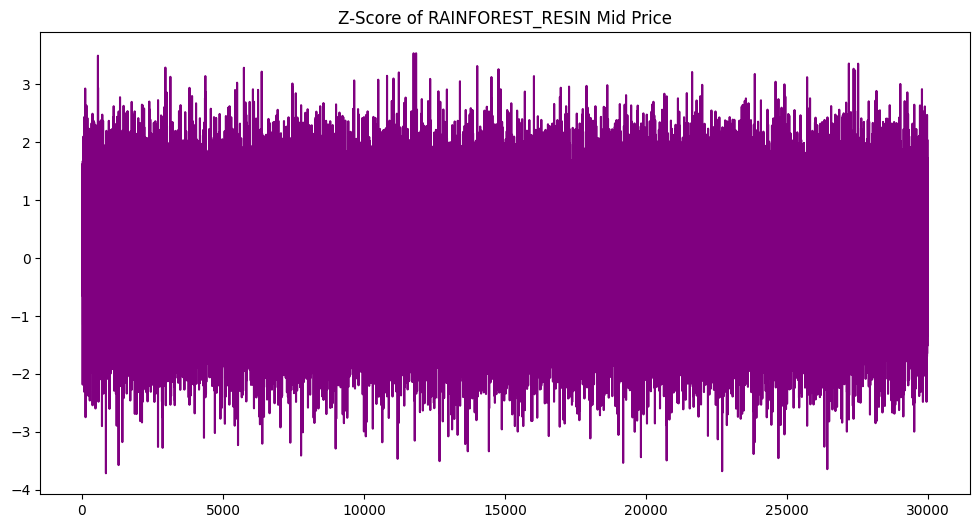

In [4]:
# Define a rolling window size. Adjust based on your preference, e.g., 20 or 50
window_size = 20

# Calculate the rolling mean and rolling standard deviation of 'mid_price'
rainforest_resin_df['rolling_mean'] = rainforest_resin_df['mid_price'].rolling(window=window_size).mean()
rainforest_resin_df['rolling_std'] = rainforest_resin_df['mid_price'].rolling(window=window_size).std()

# Calculate the Z-Score
rainforest_resin_df['z_score'] = (rainforest_resin_df['mid_price'] - rainforest_resin_df['rolling_mean']) / rainforest_resin_df['rolling_std']

# Drop rows where rolling statistics are NaN (before enough data is collected)
rainforest_resin_df.dropna(subset=['rolling_mean', 'rolling_std'], inplace=True)

rainforest_resin_df['z_score'].plot(figsize=(12, 6), title='Z-Score of RAINFOREST_RESIN Mid Price', color='purple')



The basic strategy here is to use the z-score and buy/sell when it is below/above a certain threshold.

## Finding the Pattern in Squid Ink
"the value of **Squid Ink can also swing a bit**, but some say **there is a pattern** to be discovered in its prize progression"

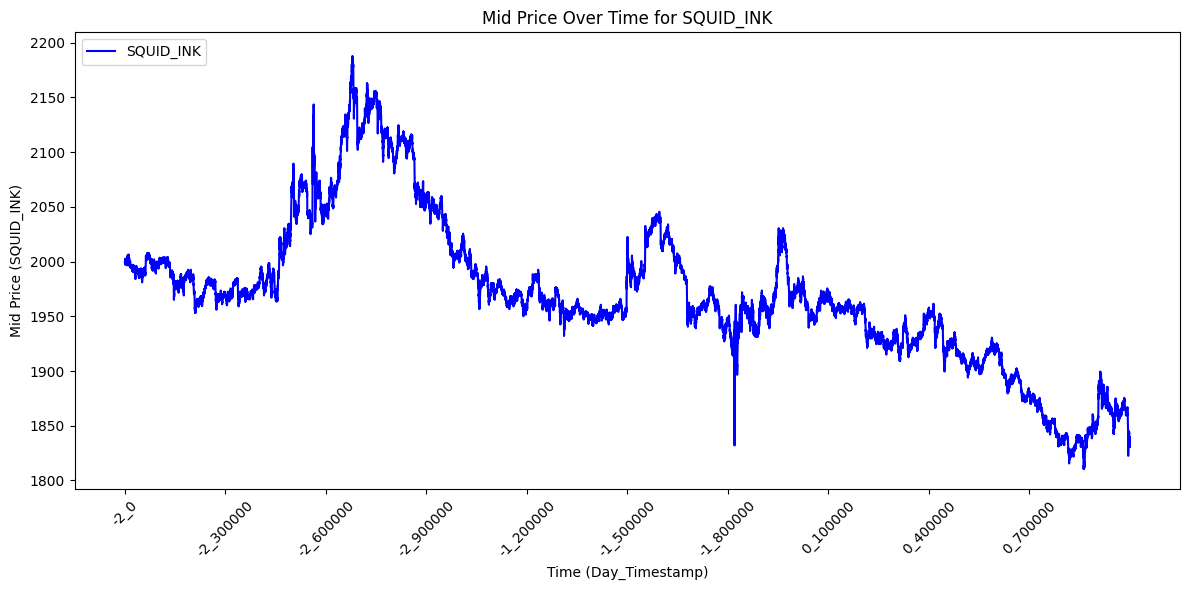

In [5]:
# first, plot only the squid ink so we can better visualize it
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(squid_ink_df['full_time'], squid_ink_df['mid_price'], label='SQUID_INK', color='blue')
ax.set_xlabel('Time (Day_Timestamp)')
ax.set_ylabel('Mid Price (SQUID_INK)')
ax.set_title('Mid Price Over Time for SQUID_INK')
ax.legend(loc='upper left')
x_ticks = squid_ink_df['full_time'][::max(1, len(squid_ink_df) // 10)]
ax.set_xticks(x_ticks)
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(squid_ink_df['mid_price'].min() * 0.99, squid_ink_df['mid_price'].max() * 1.01)  # Adjust y-axis limit for better visibility
plt.tight_layout()
plt.show()

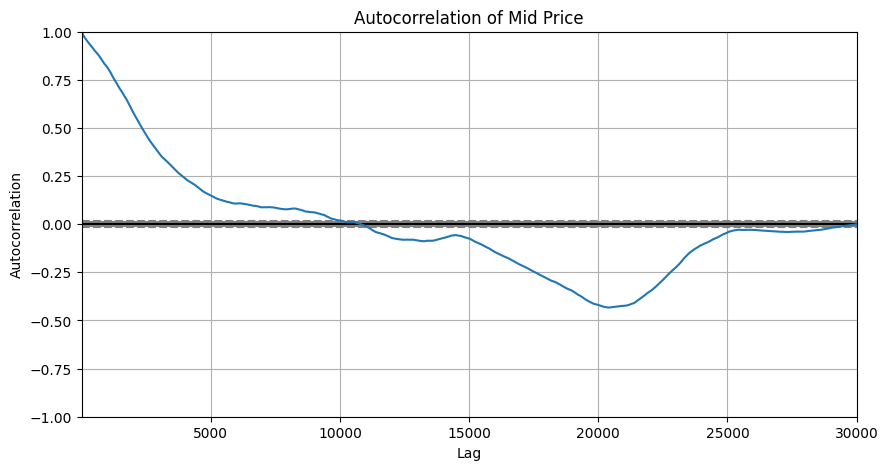

In [6]:
# perform autocorrection to see if there is correlation of price with past values
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10,5))
autocorrelation_plot(squid_ink_df['mid_price'])
plt.title('Autocorrelation of Mid Price')
plt.show()


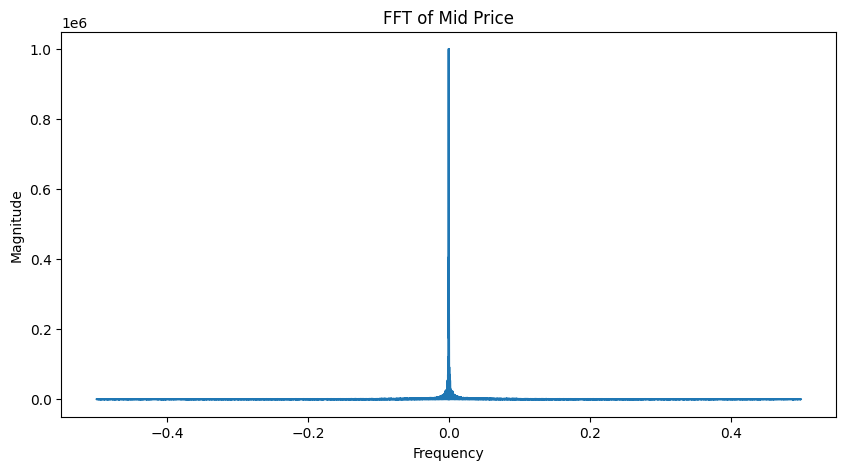

In [7]:
# foureir analysis to see fi there are dominant frequencies
import numpy as np

fft_vals = np.fft.fft(squid_ink_df['mid_price'] - squid_ink_df['mid_price'].mean())
fft_freq = np.fft.fftfreq(len(fft_vals))
plt.figure(figsize=(10,5))
plt.plot(fft_freq, np.abs(fft_vals))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('FFT of Mid Price')
plt.show()

### Try to Do a Augoregressive Model

Total SQUID_INK rows for modeling: 30000
Rows after adding lag features: 29988
Model Coefficients:
Intercept: 0.399033048356614
Lag Coefficients: [ 0.81988331  0.1248814   0.07095404 -0.01592438]


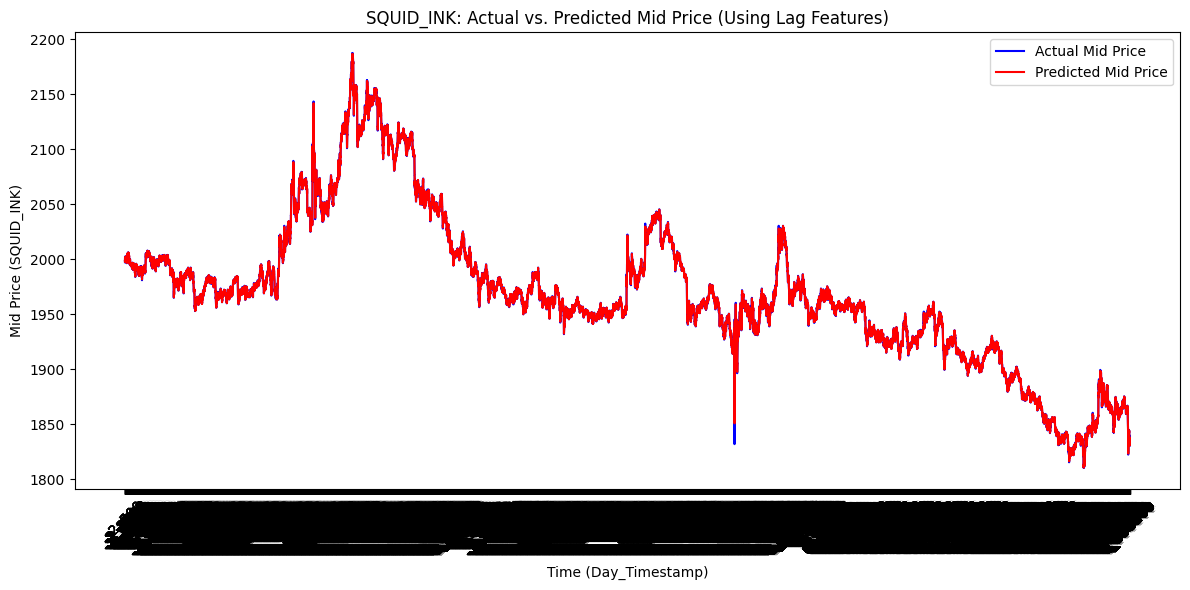

In [8]:
from sklearn.linear_model import LinearRegression

# Use the full SQUID_INK dataset (make sure this came AFTER converting mid_price to numeric)
squid_ink_full_df = combined_df[combined_df['product'] == 'SQUID_INK'].reset_index(drop=True)
print("Total SQUID_INK rows for modeling:", squid_ink_full_df.shape[0])

# Build a lagged DataFrame from the full dataset
lag = 4
squid_lag_df = squid_ink_full_df.copy()

# Apply shift within each day group
for i in range(1, lag + 1):
    squid_lag_df[f'lag_{i}'] = squid_lag_df.groupby('day')['mid_price'].shift(i)

# Drop rows that have NaN in any of the lag columns (only the first few rows in each day)
squid_lag_df.dropna(subset=[f'lag_{i}' for i in range(1, lag + 1)], inplace=True)
squid_lag_df.reset_index(drop=True, inplace=True)

print("Rows after adding lag features:", squid_lag_df.shape[0])

# Prepare features and target for the model
features = [f'lag_{i}' for i in range(1, lag + 1)]
X = squid_lag_df[features].values
y = squid_lag_df['mid_price'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

print("Model Coefficients:")
print("Intercept:", model.intercept_)
print("Lag Coefficients:", model.coef_)

# Predict the mid_price using the model
squid_lag_df['predicted_mid_price'] = model.predict(X)

# Plot actual vs. predicted mid_price over time
plt.figure(figsize=(12, 6))
plt.plot(squid_lag_df['full_time'], squid_lag_df['mid_price'], label='Actual Mid Price', color='blue')
plt.plot(squid_lag_df['full_time'], squid_lag_df['predicted_mid_price'], label='Predicted Mid Price', color='red')
plt.xlabel('Time (Day_Timestamp)')
plt.ylabel('Mid Price (SQUID_INK)')
plt.title('SQUID_INK: Actual vs. Predicted Mid Price (Using Lag Features)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
# Determine the split index (80% of the data)
split_index = int(0.8 * len(squid_lag_df))

# Create training and testing datasets based on the split index
train_df = squid_lag_df.iloc[:split_index]
test_df = squid_lag_df.iloc[split_index:]

# Define features (lag columns)
features = [f'lag_{i}' for i in range(1, 5)]  # Change 5 to your lag+1 if needed

# Prepare X (features) and y (target) for training and testing
X_train = train_df[features].values
y_train = train_df['mid_price'].values

X_test = test_df[features].values
y_test = test_df['mid_price'].values

from sklearn.linear_model import LinearRegression

# Initialize and train the model on training data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict mid_price for the test set
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R^2:", r2)

Test MSE: 1.6572180284542979
Test R^2: 0.9986213352985884


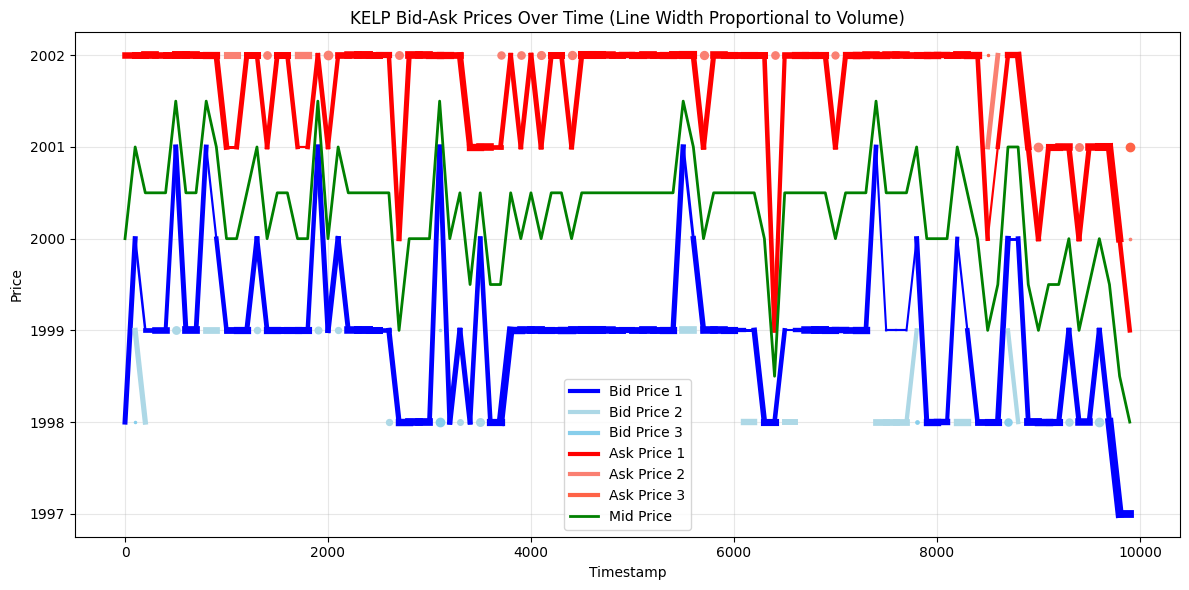

In [10]:
small_kelp_df = kelp_df[:100]

# Plot bid and ask prices
plt.figure(figsize=(12, 6))

# Dictionary to track if a label has been added to the legend yet
used_labels = {}

# Function to plot a series with breaks at NaN values and point-by-point thickness based on volume
def plot_with_point_volumes(df, x_col, y_col, volume_col, label, color, base_width=1.5):
    # Extract data
    x = df[x_col].values
    y = df[y_col].values
    
    # Get volume data, handle possible NaN values
    volumes = df[volume_col].values
    volumes = np.abs(volumes)  # Make sure volumes are positive
    
    # Create a mask for NaN prices
    mask = np.isnan(y)
    
    # If all values are NaN, just add to legend and return
    if np.all(mask):
        plt.plot([], [], color=color, label=label, linestyle='-', linewidth=base_width)
        return
    
    # Find segments of continuous non-NaN data
    idx_blocks = np.ma.clump_unmasked(np.ma.masked_array(y, mask=mask))
    
    # Calculate normalized line widths based on volume
    max_vol = np.nanmax(volumes)
    min_vol = np.nanmin(volumes) if not np.isnan(np.nanmin(volumes)) else 0
    
    if max_vol > min_vol:
        # Scale between base_width and 4*base_width
        scaled_volumes = base_width + 3 * base_width * (volumes - min_vol) / (max_vol - min_vol)
    else:
        scaled_volumes = np.ones_like(volumes) * base_width
    
    # Replace NaN volumes with the base width
    scaled_volumes = np.nan_to_num(scaled_volumes, nan=base_width)
    
    # Add to legend (done once)
    if label not in used_labels:
        plt.plot([], [], color=color, label=label, linestyle='-', linewidth=base_width*2)
        used_labels[label] = True
    
    # Draw each continuous segment with appropriate thickness
    for block in idx_blocks:
        # Convert slice to array of indices
        indices = np.arange(block.start, block.stop)
        
        # Make sure we have at least 2 points for a line
        if len(indices) > 1:
            for i in range(len(indices)-1):
                idx = indices[i]
                next_idx = indices[i+1]
                
                # Line width is the average of current and next point
                line_width = (scaled_volumes[idx] + scaled_volumes[next_idx]) / 2
                
                # Draw a line from this point to the next
                plt.plot([x[idx], x[next_idx]], [y[idx], y[next_idx]], 
                         color=color, linestyle='-', linewidth=line_width)
        elif len(indices) == 1:  # Handle single points
            idx = indices[0]
            plt.plot(x[idx], y[idx], 'o', color=color, 
                     markersize=scaled_volumes[idx], linewidth=0)

# Plot bid prices with thickness based on volume at each timestamp
plot_with_point_volumes(small_kelp_df, 'timestamp', 'bid_price_1', 'bid_volume_1', 'Bid Price 1', 'blue')
plot_with_point_volumes(small_kelp_df, 'timestamp', 'bid_price_2', 'bid_volume_2', 'Bid Price 2', 'lightblue')
plot_with_point_volumes(small_kelp_df, 'timestamp', 'bid_price_3', 'bid_volume_3', 'Bid Price 3', 'skyblue')

# Plot ask prices with thickness based on volume at each timestamp
plot_with_point_volumes(small_kelp_df, 'timestamp', 'ask_price_1', 'ask_volume_1', 'Ask Price 1', 'red')
plot_with_point_volumes(small_kelp_df, 'timestamp', 'ask_price_2', 'ask_volume_2', 'Ask Price 2', 'salmon')
plot_with_point_volumes(small_kelp_df, 'timestamp', 'ask_price_3', 'ask_volume_3', 'Ask Price 3', 'tomato')

# Plot mid price if available (with standard thickness)
if 'mid_price' in small_kelp_df.columns:
    # Create a mask for non-NaN mid prices
    mask_mid = ~np.isnan(small_kelp_df['mid_price'].values)
    
    if np.any(mask_mid):
        # Find continuous segments
        idx_blocks = np.ma.clump_unmasked(np.ma.masked_array(small_kelp_df['mid_price'].values, ~mask_mid))
        
        # Add to legend once
        plt.plot([], [], color='green', label='Mid Price', linestyle='-', linewidth=2)
        
        for block in idx_blocks:
            # Convert slice to array of indices
            indices = np.arange(block.start, block.stop)
            plt.plot(small_kelp_df['timestamp'].values[indices], 
                     small_kelp_df['mid_price'].values[indices], 
                     color='green', linestyle='-', linewidth=2)

# Add chart elements
plt.title('KELP Bid-Ask Prices Over Time (Line Width Proportional to Volume)')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

## Exploring Momentum and based Trading Strategy for Squid Ink and Kelp

In [165]:
split_data = int(0.7 * len(kelp_df))
kelp_df_is = kelp_df[:split_data]
kelp_df_os = kelp_df[split_data:]

In [ ]:

# For each price column
for col in price_columns:
    # Convert to numpy array
    y_data = kelp_df[col].values
    # Create a mask for NaN values
    mask = np.isnan(y_data)
    # Create a masked array
    masked_data = np.ma.array(y_data, mask=mask)

    # Plot the masked array
    plt.plot(df['timestamp'], masked_data, label=col)

In [184]:
small_kelp_df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_3,mid_price,profit_and_loss,full_time,signal,return,strategy_return,clr,r,ma_r
0,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,...,NaN,2000.0,0.0,-2_0,-1,0.00050,0.00000,0.000000e+00,1.0,-1.0
1,-2,100,KELP,2000,5,1999.0,6.0,1998.0,20.0,2002,...,NaN,2001.0,0.0,-2_100,-1,-0.00025,-0.00000,0.000000e+00,-0.5,0.5
2,-2,200,KELP,1999,1,1998.0,30.0,NaN,NaN,2002,...,NaN,2000.5,0.0,-2_200,-1,0.00000,0.00000,0.000000e+00,0.0,-0.0
3,-2,300,KELP,1999,27,NaN,NaN,NaN,NaN,2002,...,NaN,2000.5,0.0,-2_300,-1,0.00000,0.00000,0.000000e+00,0.0,-0.0
4,-2,400,KELP,1999,20,NaN,NaN,NaN,NaN,2002,...,NaN,2000.5,0.0,-2_400,-1,0.00050,0.00000,0.000000e+00,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-2,9500,KELP,1998,29,NaN,NaN,NaN,NaN,2001,...,NaN,1999.5,0.0,-2_9500,-1,0.00025,0.00025,7.497189e-04,0.5,-0.5
96,-2,9600,KELP,1999,3,1998.0,35.0,NaN,NaN,2001,...,NaN,2000.0,0.0,-2_9600,-1,-0.00025,-0.00025,4.996876e-04,-0.5,0.5
97,-2,9700,KELP,1998,30,NaN,NaN,NaN,NaN,2001,...,NaN,1999.5,0.0,-2_9700,1,-0.00050,-0.00050,-5.625002e-07,-1.0,-1.0
98,-2,9800,KELP,1997,32,NaN,NaN,NaN,NaN,2000,...,NaN,1998.5,0.0,-2_9800,1,-0.00025,-0.00025,-2.507814e-04,-0.5,-0.5


In [166]:
def ma_crossover_sig(df, x ,y):
    slow_ma = df['mid_price'].rolling(x).mean()
    fast_ma = df['mid_price'].rolling(y).mean()
    
    # Signal/position vector. The position at each bar
    signals = np.where(slow_ma > fast_ma, 1, -1)
    
    return signals

In [167]:
def optimize_ma_crossover(df: pd.DataFrame):
    best_pf = 0
    best_lookback = -1
    r = np.log(df['mid_price']).diff().shift(-1)
    for lookback1 in range(0, 50):
        for lookback2 in range(0, 50):
            signal = ma_crossover_sig(df, lookback1, lookback2)
            sig_rets = signal * r
            sig_pf = sig_rets[sig_rets > 0].sum() / sig_rets[sig_rets < 0].abs().sum()
    
            if sig_pf > best_pf:
                best_pf = sig_pf
                best_lookback = [lookback1, lookback2]

    return best_lookback, best_pf

## In Sample Results

/var/folders/d0/5mh0rn794xnbx40q1mtzzd4m0000gn/T/ipykernel_62591/2028821480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kelp_df_is['r'] = kelp_df_is['mid_price'].diff().shift(-1)


[7, 1] 3.6769803315077376


/var/folders/d0/5mh0rn794xnbx40q1mtzzd4m0000gn/T/ipykernel_62591/2028821480.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kelp_df_is['signal'] = signal
/var/folders/d0/5mh0rn794xnbx40q1mtzzd4m0000gn/T/ipykernel_62591/2028821480.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kelp_df_is['ma_r'] = kelp_df_is['r'] * signal


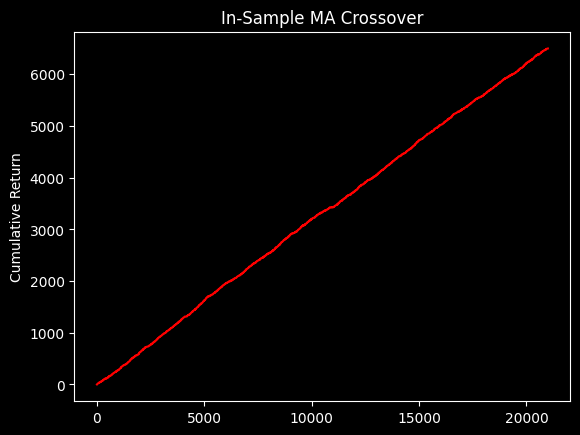

In [168]:
# not using log return because max trade size of 50
kelp_df_is['r'] = kelp_df_is['mid_price'].diff().shift(-1)
best_lookback, best_pf = optimize_ma_crossover(kelp_df_is)
print(best_lookback, best_pf)
signal = ma_crossover_sig(kelp_df_is, best_lookback[0], best_lookback[1])
kelp_df_is['signal'] = signal
kelp_df_is['ma_r'] = kelp_df_is['r'] * signal
plt.style.use("dark_background")
kelp_df_is['ma_r'].cumsum().plot(color='red')
plt.title("In-Sample MA Crossover")
plt.ylabel('Cumulative Return')
plt.show()

## Out of Sample Results

/var/folders/d0/5mh0rn794xnbx40q1mtzzd4m0000gn/T/ipykernel_62591/3657277607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kelp_df_os['r'] = kelp_df_os['mid_price'].diff().shift(-1)
/var/folders/d0/5mh0rn794xnbx40q1mtzzd4m0000gn/T/ipykernel_62591/3657277607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kelp_df_os['signal'] = signal
/var/folders/d0/5mh0rn794xnbx40q1mtzzd4m0000gn/T/ipykernel_62591/3657277607.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

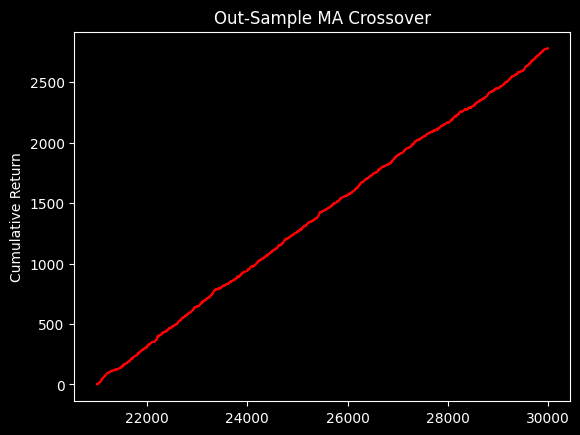

In [172]:
# not using log return because max trade size of 50
kelp_df_os['r'] = kelp_df_os['mid_price'].diff().shift(-1)
best_lookback, best_pf = optimize_ma_crossover(kelp_df_is)
signal = ma_crossover_sig(kelp_df_os, best_lookback[0], best_lookback[1])
kelp_df_os['signal'] = signal
kelp_df_os['ma_r'] = kelp_df_os['r'] * signal
plt.style.use("dark_background")
kelp_df_os['ma_r'].cumsum().plot(color='red')
plt.title("Out-Sample MA Crossover")
plt.ylabel('Cumulative Return')
plt.show()

### kelp_df_os[:20]

In [ ]:
np.sum(kelp_df['ma_r']) * 50

## In Sample Permutation Test

In [182]:
kelp_df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_3,mid_price,profit_and_loss,full_time,signal,return,strategy_return,clr,r,ma_r
0,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,...,NaN,2000.0,0.0,-2_0,-1,0.000500,0.000000,0.000000,1.0,-1.0
1,-2,100,KELP,2000,5,1999.0,6.0,1998.0,20.0,2002,...,NaN,2001.0,0.0,-2_100,-1,-0.000250,-0.000000,0.000000,-0.5,0.5
2,-2,200,KELP,1999,1,1998.0,30.0,NaN,NaN,2002,...,NaN,2000.5,0.0,-2_200,-1,0.000000,0.000000,0.000000,0.0,-0.0
3,-2,300,KELP,1999,27,NaN,NaN,NaN,NaN,2002,...,NaN,2000.5,0.0,-2_300,-1,0.000000,0.000000,0.000000,0.0,-0.0
4,-2,400,KELP,1999,20,NaN,NaN,NaN,NaN,2002,...,NaN,2000.5,0.0,-2_400,-1,0.000500,0.000000,0.000000,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,999500,KELP,2032,28,NaN,NaN,NaN,NaN,2035,...,NaN,2033.5,0.0,0_999500,-1,0.000000,0.000000,0.398386,0.0,-0.0
29996,0,999600,KELP,2032,36,NaN,NaN,NaN,NaN,2035,...,NaN,2033.5,0.0,0_999600,-1,0.000492,0.000492,0.398877,1.0,-1.0
29997,0,999700,KELP,2034,1,2032.0,26.0,NaN,NaN,2035,...,NaN,2034.5,0.0,0_999700,-1,-0.000738,-0.000000,0.398877,-1.5,1.5
29998,0,999800,KELP,2032,27,NaN,NaN,NaN,NaN,2034,...,NaN,2033.0,0.0,0_999800,1,0.000246,0.000000,0.398877,0.5,0.5
